# A step-by-step example running `flowMC`

In this tutorial we will showcase the ability of ``flowMC`` to sample efficiently a 5-dimensional multi-modal distribution. We will go through the typical steps of verification one follows to confirm the quality of the samples at the end of the MCMC run. 

First we import the necessary modules:

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

## 1 - The target distribution

The next step consists in defining the target distribution using ``jax.numpy``. This function should take as input a ``DeviceArray`` from ``jax`` representing a single realization of the variable of interest. This function will be automatically vectorized using ``jax.vmap`` in the execution of the code to handle multiple realizations at the time. 

In [2]:
from jax.scipy.special import logsumexp

n_dim = 5


def target_dual_moon(x, data=None):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))

This is a simple example of a 5-dimensional multi-modal distribution:


![Dual Moon](https://github.com/kazewong/flowMC/blob/Bayeux-example/example/notebook/dual_moon.png?raw=true)


## 2 - The initial position of walkers 

Here we are going to initialize the walkers by drawing realizations of a standard normal distribution. We now have to set the number of walkers ``n_chains``. 

Note that ``jax`` requires that random seed are explicitly defined at each stochastic step. The package provides a function ``initialize_rng_keys`` to initialize in one go all the seeds necessary for one run. 

In [3]:
n_chains = 20

rng_key, subkey = jax.random.split(jax.random.PRNGKey(42))
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dim)) * 1

2024-04-05 16:13:34.386632: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 3 - The normalizing flow

The ``flowmc`` sampler adaptively trains a normalizing flow (NF) to become an efficient proposal for non-local Metropolis-Hastings steps. The package includes two models of normalizing flows, RealNVPs and RQSpline. Here we go for the simpler class of RQSpline. 

In [16]:
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline

n_dim = 5
n_layers = 4
hidden_size = [32, 32]
num_bins = 8
data = jnp.zeros(n_dim)

rng_key, subkey = jax.random.split(rng_key)
model = MaskedCouplingRQSpline(
    n_dim, n_layers, hidden_size, num_bins, subkey
)

## 4 - Sampler initialization

The ``flowMC`` sampler combines non-local steps driven by the normalizing flow with a local sampler ensuring the MCMC progresses also in the regions that the normalizing flow has not yet learned. 

Here we will employ a MALA sampler, of which we need to choose the stepsize to be passed at run time:

In [17]:
from flowMC.proposal.MALA import MALA

MALA_Sampler = MALA(target_dual_moon, True, step_size=0.1)

Configuring the full ``flowMC`` sampler requires to specify the schedule of local sampling, global sampling with the NF proposal, and training of the NF.
- ``n_loop_training`` and ``n_loop_production`` fixes the number of cycles of the following operations
- ``n_local_steps`` is the number of iteration of the global sampler per loop
- ``n_global_steps`` is the number of Metropolis-Hastings with the NF proposal steps per loop
- ``num_epochs`` is the number of training epochs per loop

The remaining parameters that can be fixed are the training hyperparameters for the NF model: 
- ``learning_rate``, ``momentum`` and ``batchsize`` for the Adam optimizer
- ``max_samples`` which fixes the maximum number of previous walkers configuration to be used as training data

The ``Sampler`` can be initialized.

In [18]:
from flowMC.Sampler import Sampler

n_loop_training = 20
n_loop_production = 20
n_local_steps = 100
n_global_steps = 10
num_epochs = 5

learning_rate = 0.005
momentum = 0.9
batch_size = 5000
max_samples = 5000

rng_key, subkey = jax.random.split(rng_key)
nf_sampler = Sampler(
    n_dim,
    subkey,
    {'data': data},
    MALA_Sampler,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

['n_dim', 'n_chains', 'n_local_steps', 'n_global_steps', 'n_loop', 'output_thinning', 'verbose']


Everything is ready, we can launch the sampler. The first cycle of sampling-training is the slowest because of the just-in time compilation.

In [19]:
nf_sampler.sample(initial_position, data={'data':data})

Global Tuning:   0%|          | 0/30 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 20/20 [00:00<00:00, 31.35it/s]


## 5 - Checking the results

First let's look at what happened during the training run during which the global sampler was tuned. 

In [20]:
out_train = nf_sampler.get_sampler_state(training=True)
print("Logged during tuning:", out_train.keys())

Logged during tuning: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs', 'loss_vals'])


In [21]:
import corner
import matplotlib.pyplot as plt

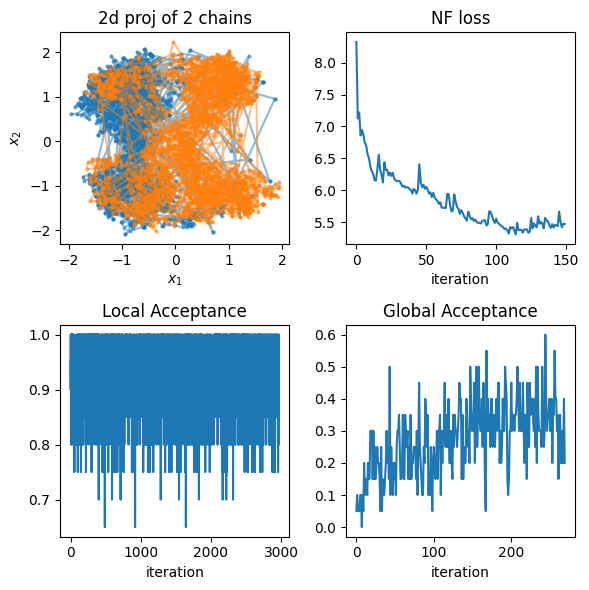

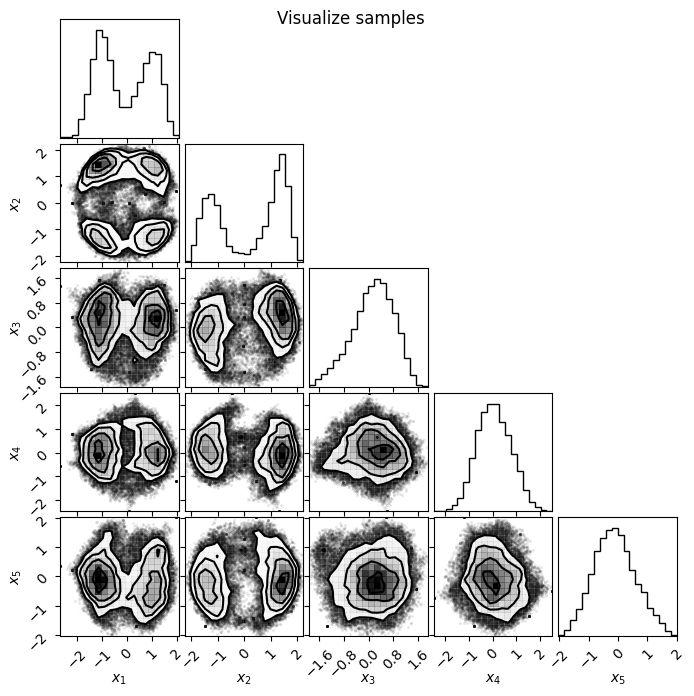

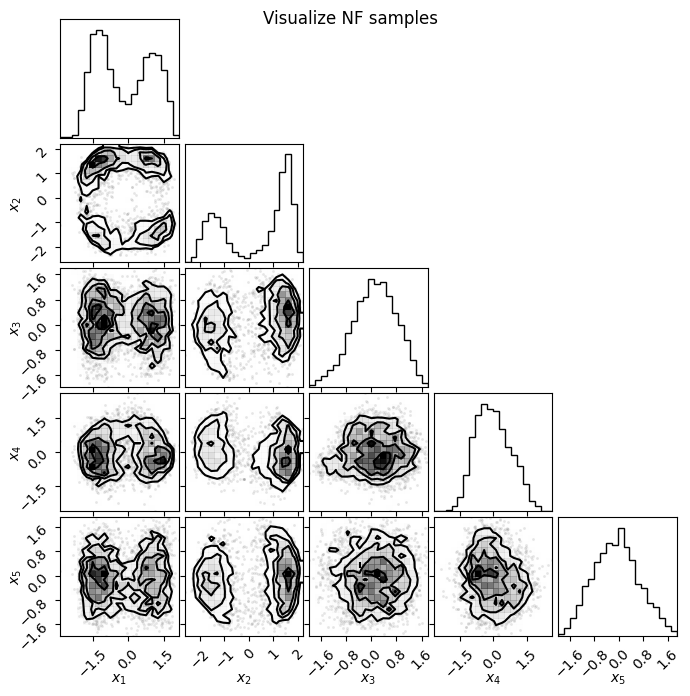

In [28]:
chains = np.array(out_train["chains"])
global_accs = np.array(out_train["global_accs"])
local_accs = np.array(out_train["local_accs"])
loss_vals = np.array(out_train["loss_vals"])
rng_key, subkey = jax.random.split(rng_key)
nf_samples = np.array(nf_sampler.sample_flow(subkey, 3000))


# Plot 2 chains in the plane of 2 coordinates for first visual check
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[0, :, 0], chains[0, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[1, :, 0], chains[1, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals.reshape(-1))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show()

Second, let's analyze the production run. We will first visualize the samples and acceptance of the local and global sampler. 

In [23]:
out_prod = nf_sampler.get_sampler_state()
print("Logged in production:", out_prod.keys())

Logged in production: dict_keys(['chains', 'log_prob', 'local_accs', 'global_accs'])


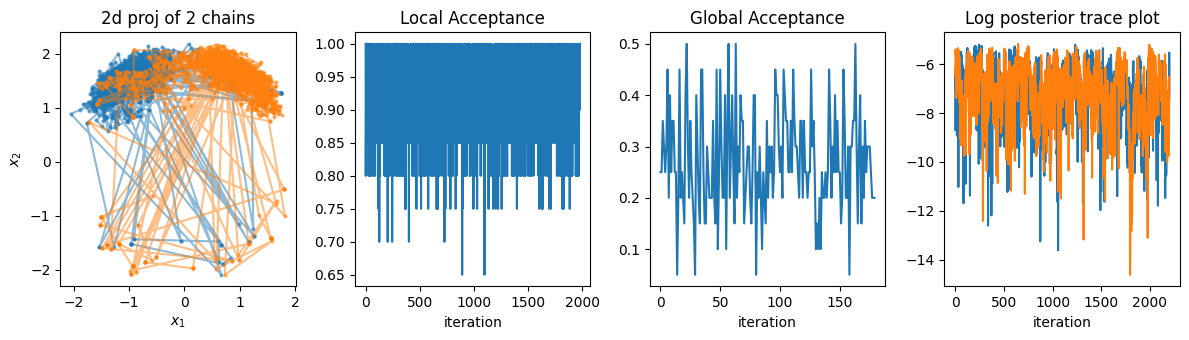

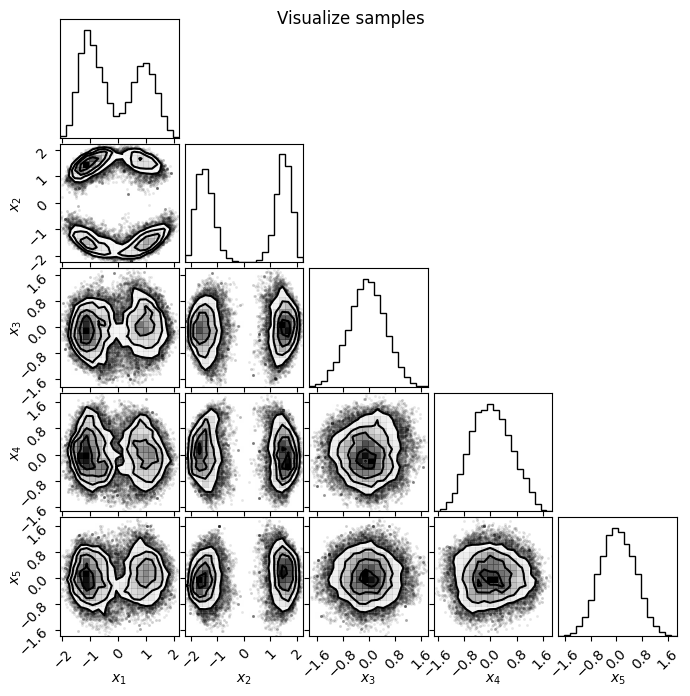

In [27]:
chains = np.array(out_prod["chains"])
index = 4  # choosing random chain index to plot results
global_accs = np.array(out_prod["global_accs"])
local_accs = np.array(out_prod["local_accs"])
log_prob_trace = np.array(out_prod["log_prob"][np.array([index, index + 10]), :]).T

plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2d proj of 2 chains")

plt.plot(chains[index, :, 0], chains[index, :, 1], "o-", alpha=0.5, ms=2)
plt.plot(chains[index + 10, :, 0], chains[index + 10, :, 1], "o-", alpha=0.5, ms=2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Log posterior trace plot")
plt.plot(log_prob_trace)
plt.xlabel("iteration")

plt.tight_layout()
plt.show(block=False)

labels = ["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
# Plot all chains
figure = corner.corner(chains.reshape(-1, n_dim), labels=labels)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
# plt.savefig('dual_moon.png')
plt.show(block=False)

Next, we use the `arviz` package to compute $\hat R$ and the Effective Sample Size (ESS) as a function of the length of the chain.

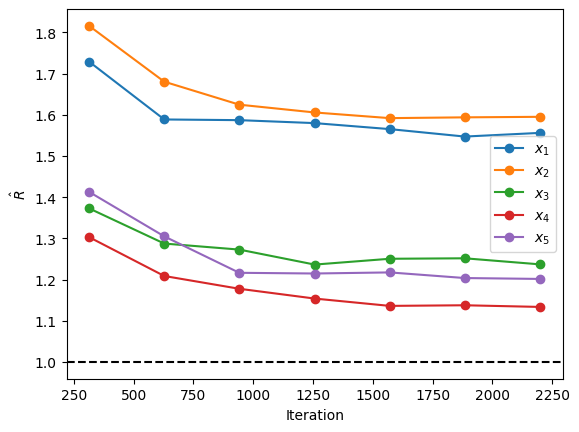

In [13]:
import arviz as az
from arviz.utils import get_coords, _var_names

## Load data as arviz InferenceData class
idata = az.convert_to_inference_data(chains)
coords = {}
data = get_coords(az.convert_to_dataset(idata, group="posterior"), coords)
var_names = None
filter_vars = None
var_names = _var_names(var_names, data, filter_vars)
n_draws = data.dims["draw"]
n_samples = n_draws * data.dims["chain"]
first_draw = data.draw.values[0]  # int of where where things should start

## Compute where to split the data to diagnostic the convergence
n_split = 7
xdata = np.linspace(n_samples / n_split, n_samples, n_split)
draw_divisions = np.linspace(n_draws // n_split, n_draws, n_split, dtype=int)

rhat_s = np.stack(
    [
        np.array(
            az.rhat(
                data.sel(draw=slice(first_draw + draw_div)),
                var_names=var_names,
                method="rank",
            )["x"]
        )
        for draw_div in draw_divisions
    ]
)

plt.figure()
plt.plot(draw_divisions, rhat_s, "-o", label=labels)
plt.axhline(1, c="k", ls="--")
plt.xlabel("Iteration")
plt.ylabel(r"$\hat{R}$")
plt.legend()